imagery_HH.tif loaded. shape: (14416, 2823, 2)


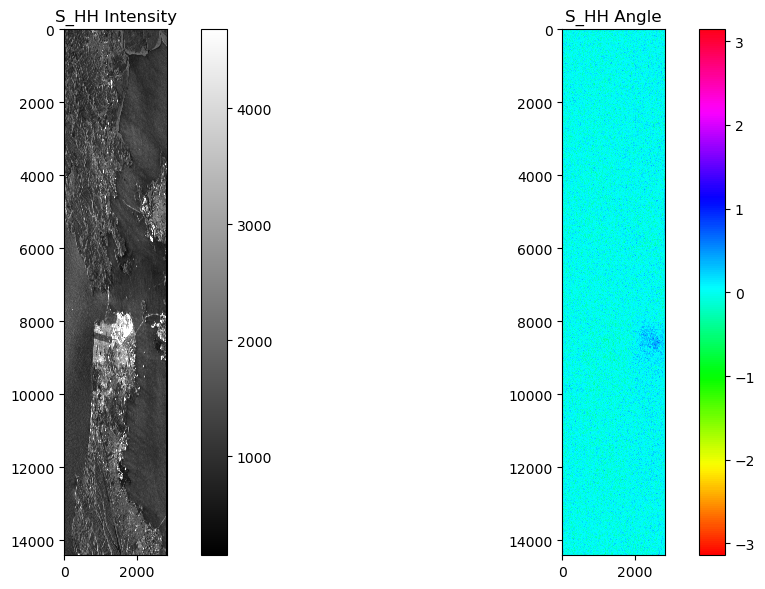

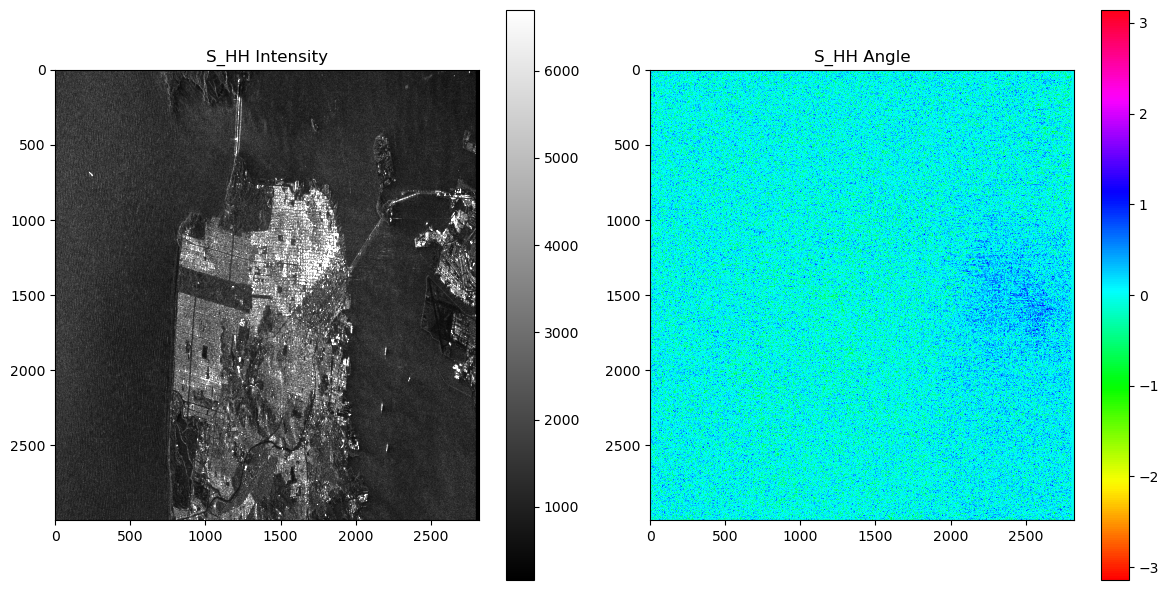

imagery_HV.tif loaded. shape: (14416, 2823, 2)
imagery_VH.tif loaded. shape: (14416, 2823, 2)
imagery_VV.tif loaded. shape: (14416, 2823, 2)
Pauli vector computed
Coherence_matrix computed
Row: 0
Memory usage: 6334.52 MB


/tmp/ipykernel_11787/83651372.py:144: RuntimeWarning: invalid value encountered in divide
  eigvals /= np.sum(eigvals)


Row: 1
Memory usage: 6334.52 MB
Row: 2
Memory usage: 6334.52 MB
Row: 3
Memory usage: 6334.65 MB
Row: 4
Memory usage: 6334.65 MB
Row: 5
Memory usage: 6334.65 MB
Row: 6
Memory usage: 6334.77 MB
Row: 7
Memory usage: 6334.77 MB
Row: 8
Memory usage: 6334.77 MB
Row: 9
Memory usage: 6334.90 MB
Row: 10
Memory usage: 6334.90 MB
Row: 11
Memory usage: 6334.90 MB
Row: 12
Memory usage: 6335.02 MB
Row: 13
Memory usage: 6335.02 MB
Row: 14
Memory usage: 6335.02 MB
Row: 15
Memory usage: 6335.15 MB
Row: 16
Memory usage: 6335.15 MB
Row: 17
Memory usage: 6335.15 MB
Row: 18
Memory usage: 6335.27 MB
Row: 19
Memory usage: 6335.27 MB
Row: 20
Memory usage: 6335.40 MB
Row: 21
Memory usage: 6335.40 MB
Row: 22
Memory usage: 6335.40 MB
Row: 23
Memory usage: 6335.52 MB
Row: 24
Memory usage: 6335.52 MB
Row: 25
Memory usage: 6335.52 MB
Row: 26
Memory usage: 6335.52 MB
Row: 27
Memory usage: 6335.65 MB
Row: 28
Memory usage: 6335.65 MB
Row: 29
Memory usage: 6335.65 MB
Row: 30
Memory usage: 6335.77 MB
Row: 31
Memory usag

/tmp/ipykernel_11787/83651372.py:246: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', 9)


Coherence_matrix computed
Row: 0
Memory usage: 6337.88 MB
Row: 1
Memory usage: 6337.88 MB
Row: 2
Memory usage: 6337.88 MB
Row: 3
Memory usage: 6338.00 MB
Row: 4
Memory usage: 6338.00 MB
Row: 5
Memory usage: 6338.00 MB
Row: 6
Memory usage: 6338.00 MB
Row: 7
Memory usage: 6338.12 MB
Row: 8
Memory usage: 6338.12 MB
Row: 9
Memory usage: 6338.12 MB
Row: 10
Memory usage: 6338.25 MB
Row: 11
Memory usage: 6338.25 MB
Row: 12
Memory usage: 6338.25 MB
Row: 13
Memory usage: 6338.38 MB
Row: 14
Memory usage: 6338.38 MB
Row: 15
Memory usage: 6338.38 MB
Row: 16
Memory usage: 6338.50 MB
Row: 17
Memory usage: 6338.50 MB
Row: 18
Memory usage: 6338.50 MB
Row: 19
Memory usage: 6338.62 MB
Row: 20
Memory usage: 6338.62 MB
Row: 21
Memory usage: 6338.62 MB
Row: 22
Memory usage: 6338.75 MB
Row: 23
Memory usage: 6338.75 MB
Row: 24
Memory usage: 6338.75 MB
Row: 25
Memory usage: 6338.88 MB
Row: 26
Memory usage: 6339.00 MB
Row: 27
Memory usage: 6339.00 MB
Row: 28
Memory usage: 6339.00 MB
Row: 29
Memory usage: 6339.

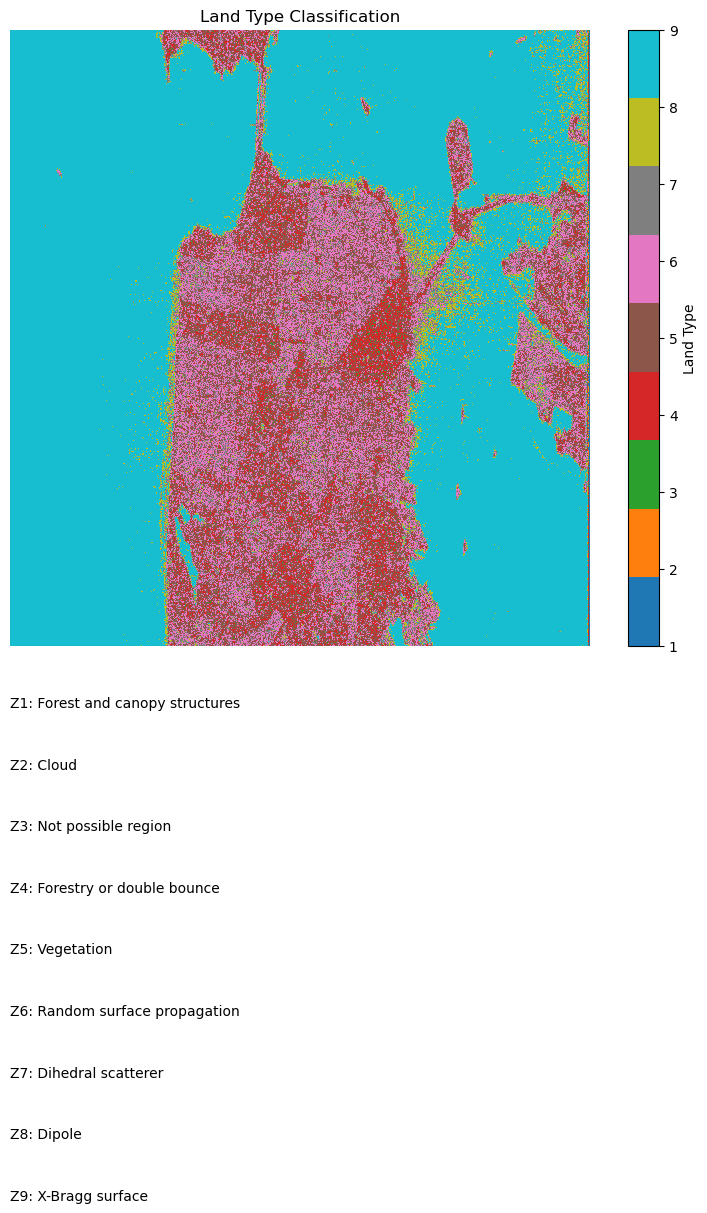

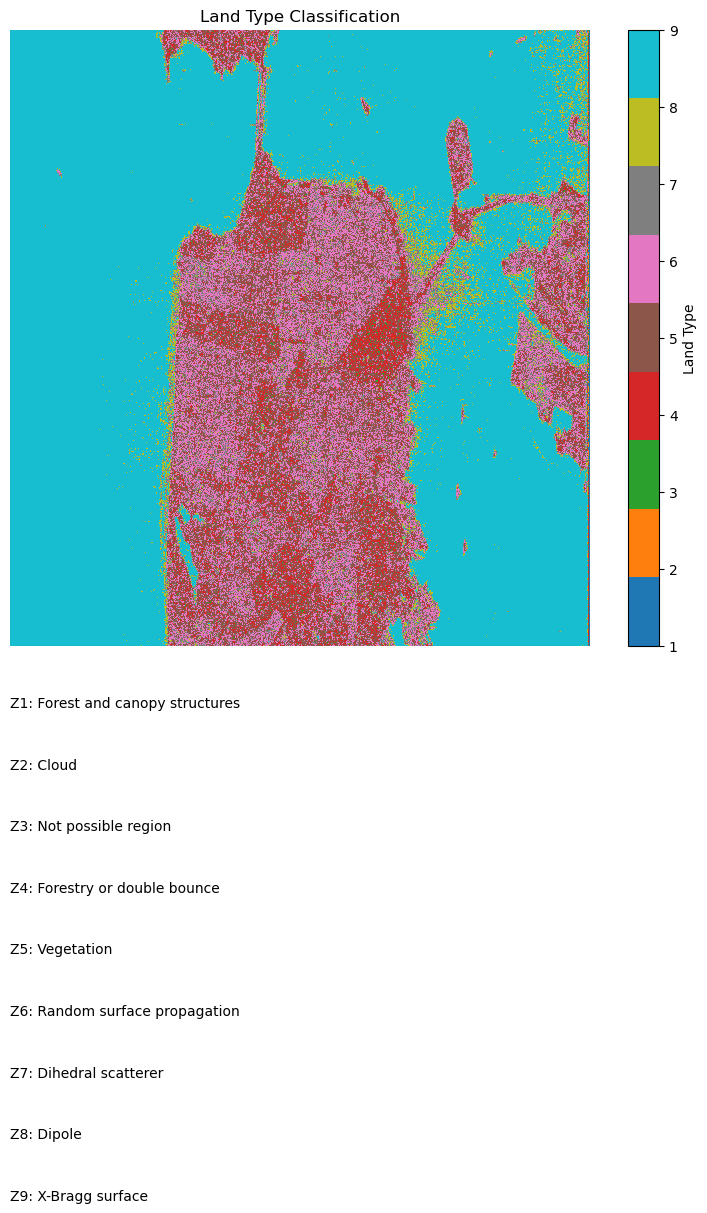

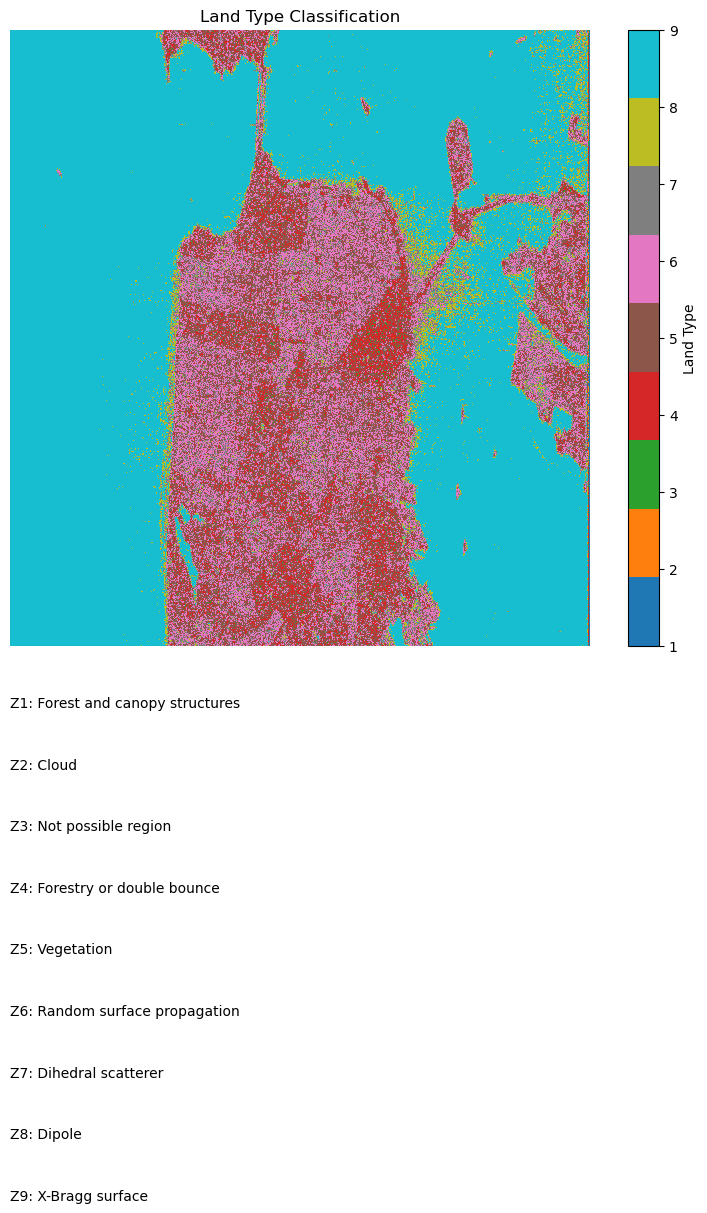

In [ ]:
import os, sys 
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter

import psutil

def memory_check():
    """
    Print the current memory usage.
    """
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / (1024 * 1024)  # Convert to MB
    print(f"Memory usage: {mem:.2f} MB")

def load_complex_data(file_path):
    """
    Load TIFF file containing real and imaginary parts in the last dimension (HxWx2) and combine them into complex data.

    Parameters:
        file_path (str): Path to the TIFF file.

    Returns:
        np.ndarray: Complex-valued 2D array.
    """
    data = tiff.imread(file_path)
    print(f"{file_path} loaded. shape: {data.shape}")

    if data.shape[-1] != 2:
        raise ValueError("Expected input data with last dimension as 2 for real and imaginary parts.")

    real_part = data[:, :, 0]
    imag_part = data[:, :, 1]

    return real_part + 1j * imag_part

def compute_pauli_vector(HH, HV, VH, VV):
    """
    Compute the Pauli vector representation using the provided polarimetric channels.

    Parameters:
        HH (np.ndarray): HH polarization complex data.
        HV (np.ndarray): HV polarization complex data.
        VH (np.ndarray): VH polarization complex data.
        VV (np.ndarray): VV polarization complex data.

    Returns:
        np.ndarray: 3xHxW Pauli vector.
    """
    # Pauli vector components
    pauli_1 = (HH + VV) / np.sqrt(2)
    pauli_2 = (HH - VV) / np.sqrt(2)
    pauli_3 = (HV + VH) / np.sqrt(2)

    print("Pauli vector computed")
    
    return np.stack([pauli_1, pauli_2, pauli_3], axis=0)

def compute_coherence_matrix(pauli_vector, window_size, block_size):
    """
    Compute the coherence matrix by processing block-by-block with neighborhood averaging.

    Parameters:
        pauli_vector (np.ndarray): 3xHxW Pauli vector.
        window_size (int): Size of the averaging window.
        block_size (int): Size of the processing blocks.

    Returns:
        np.ndarray: Coherence matrix with shape (3, 3, H, W).
    """
    H, W = pauli_vector.shape[1:]
    coherence_matrix = np.zeros((3, 3, H, W), dtype=np.complex64)
    pad_size = window_size // 2

    # Pad the Pauli vector to handle edge effects
    padded_pauli_vector = np.pad(pauli_vector, ((0, 0), (pad_size, pad_size), (pad_size, pad_size)), mode='reflect')

    for row_start in range(0, H, block_size):
        for col_start in range(0, W, block_size):
            row_end = min(row_start + block_size, H)
            col_end = min(col_start + block_size, W)

            # Add padding to the block for neighborhood filtering
            padded_row_start = row_start + pad_size
            padded_col_start = col_start + pad_size
            padded_row_end = row_end + pad_size
            padded_col_end = col_end + pad_size

            block = padded_pauli_vector[:, padded_row_start - pad_size:padded_row_end + pad_size,
                                        padded_col_start - pad_size:padded_col_end + pad_size]

            block_coherence = np.zeros((3, 3, block.shape[1] - 2 * pad_size, block.shape[2] - 2 * pad_size), dtype=np.complex64)

            # Compute block coherence matrix
            for i in range(3):
                for j in range(3):
                    block_coherence_full = block[i] * np.conj(block[j])

                    # Apply neighborhood averaging
                    block_coherence_avg = uniform_filter(block_coherence_full.real, size=window_size) + \
                                          1j * uniform_filter(block_coherence_full.imag, size=window_size)

                    # Trim the padding
                    block_coherence[i, j] = block_coherence_avg[pad_size:-pad_size, pad_size:-pad_size]

            # Assign back to the global coherence matrix
            coherence_matrix[:, :, row_start:row_end, col_start:col_end] = block_coherence

    print("Coherence_matrix computed")

    return coherence_matrix

def cloude_pottier_decomposition(pauli_vector, reference_vector, window_size=3, block_size=10):
    """
    Perform Cloude-Pottier decomposition to compute entropy, alpha angle, and classify land types.

    Parameters:
        pauli_vector (np.ndarray): 3xHxW Pauli vector.
        window_size (int): Size of the averaging window for the coherence matrix.
        block_size (int): Size of the processing blocks.

    Returns:
        tuple: Entropy (H), Alpha angle (alpha), and land type classification (Z).
    """
    H, W = pauli_vector.shape[1:]
    coherence_matrix = compute_coherence_matrix(pauli_vector, window_size, block_size)

    entropy = np.zeros((H, W))
    alpha = np.zeros((H, W))
    Z = np.zeros((H, W), dtype=np.uint8)

    # reference_vector = np.array([0, 0, 1], dtype=np.complex64)

    for i in range(H):
        print(f"Row: {i}")
        memory_check()
        for j in range(W):
            local_matrix = coherence_matrix[:, :, i, j]

            # Eigenvalue decomposition
            eigvals, eigvecs = np.linalg.eigh(local_matrix)
            eigvals = np.abs(eigvals)
            eigvals /= np.sum(eigvals)

            # Calculate entropy and alpha
            entropy[i, j] = -np.sum(eigvals * np.log(eigvals + 1e-10))

            # #Compute the mean alpha
            
            angles = np.arccos(np.clip(np.abs(np.dot(eigvecs.T, reference_vector)), 0, 1))
            angles_degrees = angles * (180 / np.pi)
            alpha[i, j] = np.sum(eigvals * angles_degrees)

            # angles = np.arccos(np.clip(np.abs(eigvecs[0, :]), 0, 1))  # Angles with reference [1, 0, 0] by default
            # angles_degrees = angles * (180 / np.pi)
            # alpha[i, j] = np.sum(eigvals * angles_degrees)

            # Land type classification
            if entropy[i, j] >= 0.9 and alpha[i, j] >= 55:
                Z[i, j] = 1  # Z1: Forest and canopy structures
            elif entropy[i, j] >= 0.9 and alpha[i, j] >= 42:
                Z[i, j] = 2  # Z2: Cloud
            elif entropy[i, j] >= 0.9 and alpha[i, j] >= 40:
                Z[i, j] = 3  # Z3: Not possible region
            elif entropy[i, j] >= 0.5 and alpha[i, j] >= 50:
                Z[i, j] = 4  # Z4: Forestry or double bounce
            elif entropy[i, j] >= 0.5 and alpha[i, j] >= 40:
                Z[i, j] = 5  # Z5: Vegetation
            elif entropy[i, j] >= 0.5 and alpha[i, j] < 40:
                Z[i, j] = 6  # Z6: Random surface propagation
            elif entropy[i, j] < 0.5 and alpha[i, j] >= 48:
                Z[i, j] = 7  # Z7: Dihedral scatterer
            elif entropy[i, j] < 0.5 and alpha[i, j] >= 42:
                Z[i, j] = 8  # Z8: Dipole
            elif entropy[i, j] < 0.5 and alpha[i, j] < 42:
                Z[i, j] = 9  # Z9: X-Bragg surface
            else:
                ValueError("alpha / entropy values are not valid")

    print("cloude_pottier_decomposition")

    return entropy, alpha, Z

def save_as_tiff(output_path, data, reference_file):
    """
    Save a complex-valued 2D array as a multi-band TIFF file.

    Parameters:
        output_path (str): Path to save the TIFF file.
        data (np.ndarray): Data to save (supports real, complex, or multi-band).
        reference_file (str): Path to a reference TIFF file for shape and metadata.

    Returns:
        None
    """
    reference_data = tiff.imread(reference_file)
    shape = reference_data.shape[:2]

    tiff.imwrite(output_path, data.astype(np.float32), dtype=np.float32)

def plot_intensity_and_angle(data, title_prefix):
    """
    Plot the intensity and angle of a complex dataset.

    Parameters:
        data (np.ndarray): Complex-valued 2D array.
        title_prefix (str): Prefix for the plot titles.

    Returns:
        None
    """
    intensity = np.abs(data)
    angle = np.angle(data)

    lower = np.percentile(intensity, 2)
    upper = np.percentile(intensity, 98)

    plt.figure(figsize=(12, 6))

    # Plot intensity
    plt.subplot(1, 2, 1)
    plt.imshow(intensity, cmap="gray", vmin=lower, vmax=upper)
    plt.title(f"{title_prefix} Intensity")
    plt.colorbar()

    # Plot angle
    plt.subplot(1, 2, 2)
    plt.imshow(angle, cmap="hsv")
    plt.title(f"{title_prefix} Angle")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

def plot_land_classification(Z):
    """
    Plot the land type classification with labeled regions.

    Parameters:
        Z (np.ndarray): Land type classification map.

    Returns:
        None
    """
    # Define a colormap and labels for the land types
    cmap = plt.cm.get_cmap('tab10', 9)
    labels = [
        "Z1: Forest and canopy structures",
        "Z2: Cloud",
        "Z3: Not possible region",
        "Z4: Forestry or double bounce",
        "Z5: Vegetation",
        "Z6: Random surface propagation",
        "Z7: Dihedral scatterer",
        "Z8: Dipole",
        "Z9: X-Bragg surface"
    ]

    plt.figure(figsize=(10, 8))
    plt.imshow(Z, cmap=cmap, vmin=1, vmax=9)
    plt.colorbar(ticks=np.arange(1, 10), label="Land Type")

    # Add labels as text
    for i, label in enumerate(labels, start=1):
        plt.text(0, -i * 0.1, label, fontsize=10, transform=plt.gca().transAxes)

    plt.title("Land Type Classification")
    plt.axis("off")


# Example usage
if __name__ == "__main__":
    # Load complex radar data
    base_dir = "/home/renaud//Data/polymetric_data/SAN_FRANCISCO_RS2"
    os.chdir(base_dir)
        
    S_HH = load_complex_data("imagery_HH.tif")
    plot_intensity_and_angle(S_HH, "S_HH")

    xslice = slice(7000,10000)
    yslice = slice(None)  
    S_HH = S_HH[xslice, yslice]
    plot_intensity_and_angle(S_HH, "S_HH")

    S_HV = load_complex_data("imagery_HV.tif")
    S_HV = S_HV[xslice, yslice]
    S_VH = load_complex_data("imagery_VH.tif")
    S_VH = S_VH[xslice, yslice]
    S_VV = load_complex_data("imagery_VV.tif")
    S_VV = S_VV[xslice, yslice]

    pauli_vector = compute_pauli_vector(S_HH, S_HV, S_VH, S_VV)
    reference_vector = np.array([1, 0, 0], dtype=np.complex64)
    entropy, alpha, Z = cloude_pottier_decomposition(pauli_vector, reference_vector,  window_size=3, block_size=256)
    plot_land_classification(Z)
    reference_vector = np.array([0, 1, 0], dtype=np.complex64)
    entropy, alpha, Z = cloude_pottier_decomposition(pauli_vector, reference_vector,  window_size=3, block_size=256)
    plot_land_classification(Z)
    reference_vector = np.array([0, 0, 1], dtype=np.complex64)
    entropy, alpha, Z = cloude_pottier_decomposition(pauli_vector, reference_vector,  window_size=3, block_size=256)
    plot_land_classification(Z)
